# <center>组分析过程</center>

In [1]:
import sys
sys.path.append('/home/hcp/anaconda3/envs/xj/lib/python3.8/site-packages')
import os
import numpy as np
import pandas as pd
from glob import glob
from bids import BIDSLayout
from nilearn import plotting
import matplotlib.pyplot as plt
from nilearn.image import mean_img
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.reporting import make_glm_report, get_clusters_table
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain, plot_design_matrix, plot_contrast_matrix

/home/hcp/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def build_Subs():
    path = '/mnt/sdb1/Judge-fMRI/Data/AnalysisData/Information_of_trials.txt'
    with open(path, 'r', encoding='utf-8') as f:
        f_data = f.read().split('\n')
        data = f_data[3:]
        judge_subs = f_data[1].split(',')
        layperson_subs = f_data[2].split(',')

    build_subs_dict = {}
    for i in data:
        li = i.split(',')
        build_subs_dict[li[0]] = []
        for j in range(int((len(li)-1)/2)):
            build_subs_dict[li[0]].append([li[2*j+1], li[(j+1)*2]])

    return judge_subs, layperson_subs, build_subs_dict

judge_subs, layperson_subs, build_subs_dict = build_Subs()
print(judge_subs)
print(layperson_subs)

['001', '002', '003', '005', '006', '007', '008', '009', '010', '014', '015', '019', '022', '023', '024', '025']
['031', '033', '034', '035', '038', '042', '044', '046', '047', '050', '051', '053']


# <center>目录</center>
# 1 配对t检验
## ——1.1输入数据
## ——1.2设计矩阵
## ——1.3二阶模型
## ——1.4计算统计量z分数
## ——1.5FDR多重比较校正 & 打印坐标点

**********

### 1.1输入数据

In [5]:
outdir = '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620'
n_subjects = len(judge_subs) # TODO：judge人共有25名
print(n_subjects)
moral_z_maps = sorted(glob(os.path.join(outdir, '*moral_zmap.nii.gz')))[:n_subjects]
judge_z_maps = sorted(glob(os.path.join(outdir, '*legal_zmap.nii.gz')))[:n_subjects]
print(len(moral_z_maps))
print(len(judge_z_maps))
second_level_input = moral_z_maps + judge_z_maps
second_level_input

16
16
16


['/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-001-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-002-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-003-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-005-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-006-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-007-moral_zmap.nii.gz',
 '/mnt/sdb1/Judge-fMRI/Scripts/AnalysisScripts/GLM-FirstLevelAnalysis/results_drop_trials_only_on_DesignMatrix_0620/sub-008-moral_zmap.n

### 1.2设计矩阵

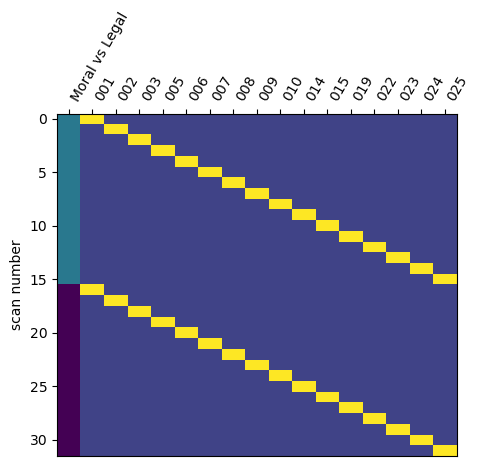

,Moral vs Legal,001,002,003,005,006,007,008,009,010,014,015,019,022,023,024,025
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
condition_effect = np.hstack(([1] * n_subjects, [-1] * n_subjects))

paired_design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=["Moral vs Legal"] + judge_subs,
)
plot_design_matrix(paired_design_matrix)
plt.show()
paired_design_matrix

### 1.3二阶模型

In [8]:
second_level_model_paired = SecondLevelModel(n_jobs=4).fit(
    second_level_input, design_matrix=paired_design_matrix
)

### 1.4计算统计量——无需指定对比矩阵，仅需指定单个参数

In [9]:
z_maps_paired = second_level_model_paired.compute_contrast("Moral vs Legal", output_type="z_score")

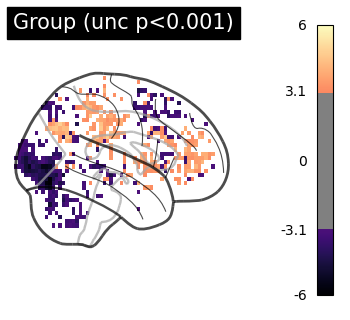

The unc threshold is 3.09


In [10]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

plotting.plot_glass_brain(z_maps_paired, colorbar=True, threshold=p001_unc,
                          title='Group (unc p<0.001)',
                          plot_abs=False, display_mode='x', cmap='magma')
plotting.show()
print(f"The unc threshold is {p001_unc:.3g}")

### 1.5FDR多重比较校正 & 打印坐标点

In [11]:
thresholded_map, threshold = threshold_stats_img(
    z_maps_paired, alpha=.05, height_control='fdr', cluster_threshold=0)
print(f"The FDR=.05 threshold is {threshold:.3g}")

The FDR=.05 threshold is 3.56


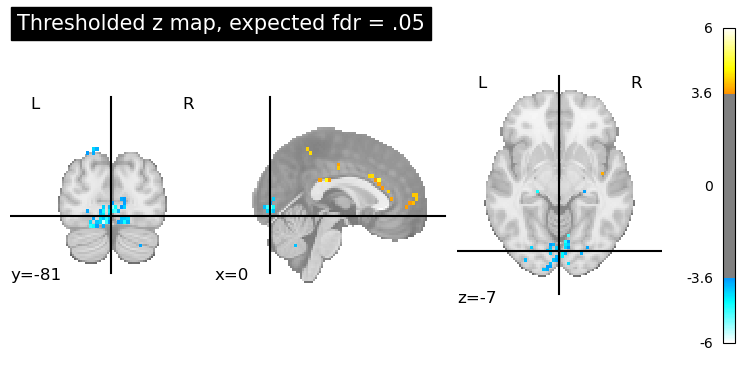

In [12]:
plotting.plot_stat_map(
    thresholded_map,
    title="Thresholded z map, expected fdr = .05",
    threshold=threshold,
)

In [18]:
# table = get_clusters_table(thresholded_map, stat_threshold=0, cluster_threshold=0)#TODO:此时的stat_threshold小于上面的阈值时都无效
# table

table = get_clusters_table(thresholded_map, stat_threshold=3.1, cluster_threshold=20)#TODO:此时的stat_threshold小于上面的阈值时都无效
table

/tmp/ipykernel_32030/1609229098.py:4: UserWarning: Attention: No clusters with stat higher than 3.1
  table = get_clusters_table(thresholded_map, stat_threshold=3.1, cluster_threshold=20)#TODO:此时的stat_threshold小于上面的阈值时都无效


,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


In [19]:
name = "judge_Moral_legal"
thresholded_map.to_filename(name + ".nii.gz")

In [22]:
# todo:.tsv
table.to_csv(name + ".csv")

In [27]:
from atlasreader import create_output
# create_output(name + ".nii.gz", cluster_extent=0)
create_output(name + ".nii.gz", cluster_extent=20)

In [28]:
peak_info = pd.read_csv(name + '_peaks.csv')
peak_info

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-12.5,-78.5,-14.75,-6.034240,3881.25,Lingual_L,ctx-lh-lingual,29.0% Left_Lingual_Gyrus; 25.0% Left_Occipital...
1,2.0,-12.5,-96.5,0.25,-5.441978,877.50,Occipital_Mid_L,Left-Cerebral-White-Matter,55.0% Left_Occipital_Pole


In [33]:
# cluster_info = pd.read_csv(name + '_clusters.csv')
cluster_info.to_csv(name + '_clusters.tsv', sep='\t',index=False)


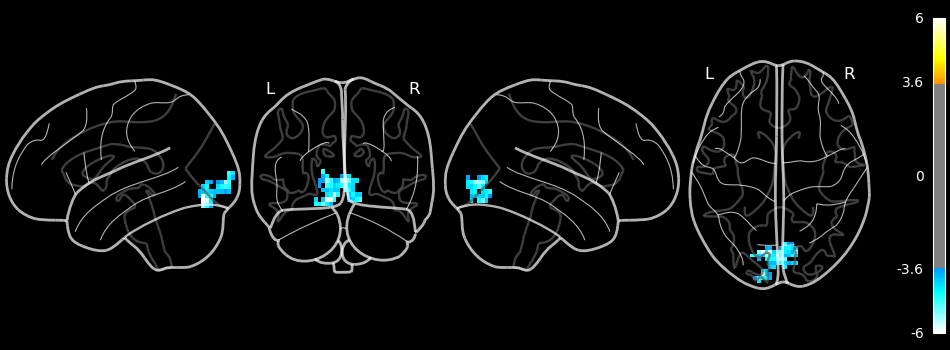

In [31]:
from IPython.display import Image
Image(name + ".png")